In [1]:
import numpy as np
import scipy.io as sio
import scipy.linalg as slinalg
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append("../")
import ICP
import importlib
from PDE2D import *
from PDEND import largeimg
from Mahalanobis import *
from SyntheticExamples import FlatTorusIdeal
from Kuramoto import *
from Mahalanobis import *
from LocalPCA import *
from ripser import ripser
from persim import plot_diagrams as plot_dgms

In [2]:
seed = 8
np.random.seed(seed)

theta1 = np.pi/3
theta2 = 0
fac = 0.5
Win = 80
pd1 = (80, 1)
pd2 = (45, 45)
N = 5500
cropheight = 250 #195


delta = 2
n_points = 100
rank = 2
pca_dim = 120
maxeigs = 90
dMaxSqr = 1000


ks1 = KSSimulation(co_rotating=False, scale=(fac*7, fac/2), reldir='../')
ks1.crop(0, cropheight, 0, ks1.I.shape[1])
ks1.makeObservations(pd1, N)
ks1.thetas[0:N] = theta1
ks1.completeObservations()
ks1.resort_byraster()

ks2 = KSSimulation(co_rotating=False, scale=(fac*7, fac/2), reldir='../')
ks2.crop(0, cropheight, 0, ks2.I.shape[1])
ks2.makeObservations(pd2, N)
ks2.thetas[0:N] = theta2
ks2.completeObservations()
ks2.resort_byraster()

pdes = [ks1, ks2]
for ks in pdes:
    if pca_dim < ks.patches.shape[1]:
        ks.compose_with_dimreduction(dim=pca_dim)



Making 5500 observations of dimension (80, 1) on a grid of (250, 100)...
Elapsed time patch sampling: 0.123
Elapsed time patch sampling: 0.12
Making 5500 observations of dimension (45, 45) on a grid of (250, 100)...
Elapsed time patch sampling: 2.74
Elapsed time patch sampling: 2.68
Reducing patch dimensions from 2025 to 120


(5500, 80)
Computing Jacobians, rank = 2, maxiegs = 80...
0 of 5500
500 of 5500
1000 of 5500
1500 of 5500
2000 of 5500
2500 of 5500
3000 of 5500
3500 of 5500
4000 of 5500
4500 of 5500
5000 of 5500
Elapsed Time: 15.7
Computing Mahalanobis Distances...
Elapsed Time: 76.2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 Elapsed Time: 839
(5500, 120)
Computing Jacobians, rank = 2, maxiegs = 90...
0 of 5500
500 of 5500
1000 of 5500
1500 of 5500
2000 of 5500
2500 of 5500
3000 of 5500
3500 of 5500
4000 of 5500
4500 of 5500
5000 of 5500
Elapsed Time: 352
Computing Mahalanobis Distances...
Elapsed Time: 79.7
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 

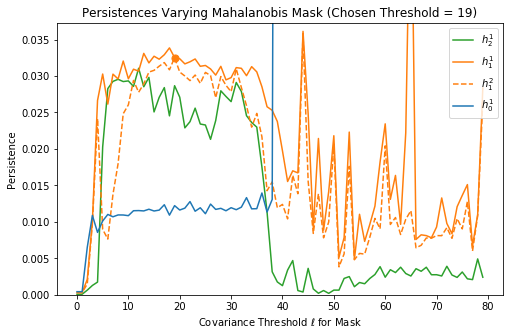

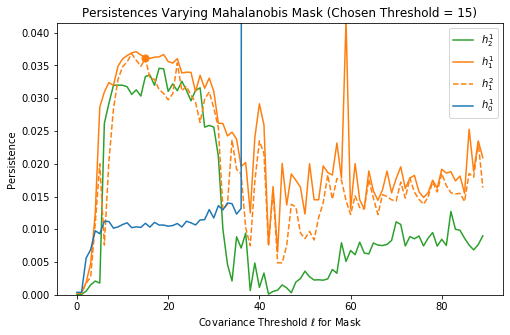

In [3]:
## Perform diffusion maps on each set individually
Ys = []
alldgms = []
for i in range(2):
    ksi = pdes[i]
    print(ksi.patches.shape)

    ## Step 1: Compute Mahalanobis and autotune mask using TDA
    res = getMahalanobisDists(ksi.patches, ksi.get_mahalanobis_ellipsoid, delta, \
                          n_points=n_points, rank=rank, maxeigs=maxeigs)
    gamma, maskidx = res["gamma"], res["maskidx"]
    ## Compute diffusion maps and TDA at all thresholds of the mask
    eps = dMaxSqr*np.max(gamma)*1e-3 # Autotune diffusion eps in terms of point cloud diameter
    # Try different thresholds of the Mahalanobis mask
    res = getMahalanobisAllThresh(gamma, maskidx, eps=eps, neigs=8, verbose=True)
    plt.figure(figsize=(8, 5))
    scores = getTorusPersistenceScores(res["alldgms"], do_plot=True)["scores"]
    thresh = np.argmax(scores)
    mask = np.array(maskidx >= thresh, dtype=float)
    Y = getDiffusionMap(gamma, eps=eps, distance_matrix=True, mask=mask, neigs=8)
    dgms = ripser(Y, n_perm=400, maxdim=2)['dgms']
    Ys.append(Y)
    alldgms.append(dgms)

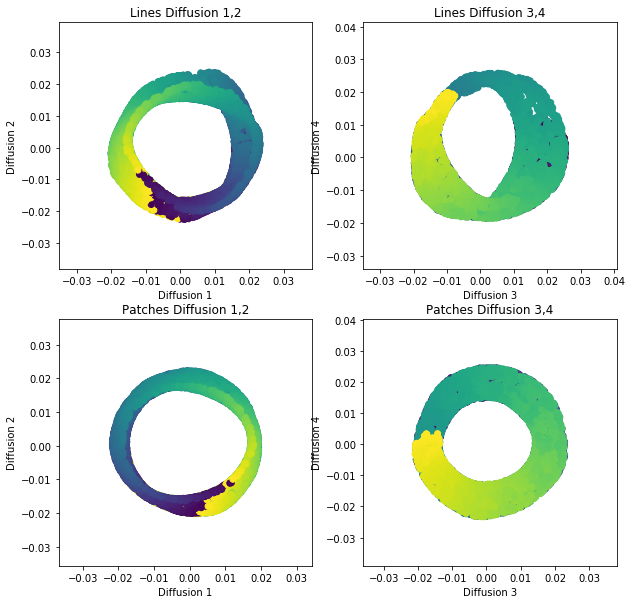

In [4]:
plt.figure(figsize=(10, 10))
labels = ["Lines", "Patches"]
for i in range(2):
    plt.subplot(2, 2, i*2+1)
    plt.scatter(Ys[i][:, 0], Ys[i][:, 1], c=pdes[i].Xs, cmap='viridis')
    plt.xlabel("Diffusion 1")
    plt.ylabel("Diffusion 2")
    plt.title("%s Diffusion 1,2"%labels[i])
    plt.subplot(2, 2, i*2+2)
    plt.scatter(Ys[i][:, 2], Ys[i][:, 3], c=pdes[i].Ts, cmap='viridis')
    plt.xlabel("Diffusion 3")
    plt.ylabel("Diffusion 4")
    plt.title("%s Diffusion 3,4"%labels[i])
plt.savefig("LinesToPatches_DiffusionTDA.svg", bbox_inches='tight')

rmse=0.11


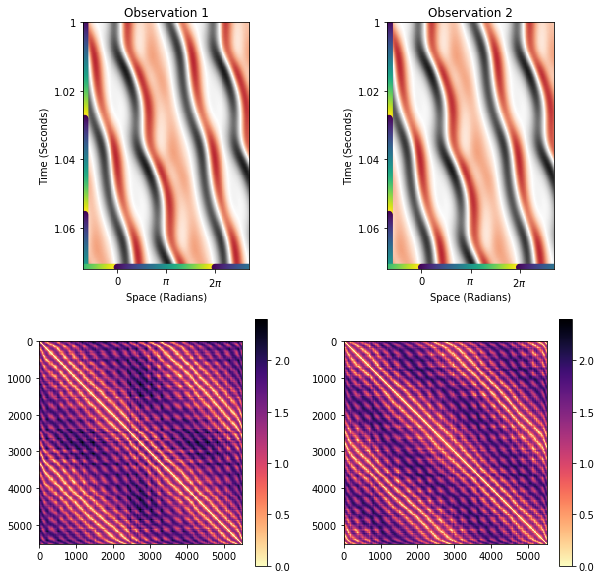

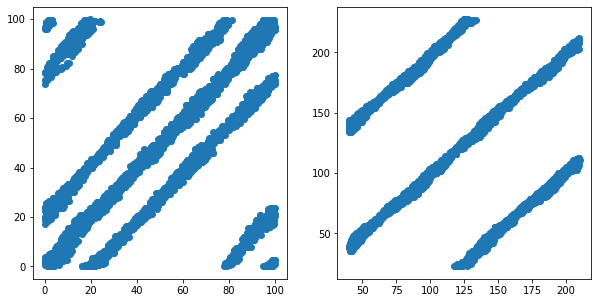

In [5]:
## Align the two patch sets using some correspondences
from SyntheticExamples import FlatTorusIdeal
importlib.reload(ICP)

seed = 2
np.random.seed(seed)
ncorresp = 4
x1 = np.array([pdes[0].Xs, pdes[0].Ts])
x2 = np.array([pdes[1].Xs, pdes[1].Ts])
D = ICP.getCSM(x1, x2)
D = np.argmin(D, 1)
idx = np.random.permutation(np.arange(Ys[0].shape[0]))[0:ncorresp]
corresp = np.zeros((ncorresp, 2), dtype=int)
corresp[:, 0] = idx
corresp[:, 1] = D[idx]
weights = np.ones(Ys[0].shape[0])
weights[idx] = 2000

idxMin = ICP.doICP_PDE2D(pdes[0], Ys[0][:, 0:4], pdes[1], Ys[1][:, 0:4], corresp=corresp, weights=weights, \
                         initial_guesses=1, do_plot=False, MaxIters=200)['idxMin']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(x1[0, :], x2[0, idxMin[-1]])
plt.subplot(122)
plt.scatter(x1[1, :], x2[1, idxMin[-1]])
plt.savefig("ICP%i.svg"%seed)

In [6]:
pdes[1].f_patch = lambda x: x
pdes[1].completeObservations()

Elapsed time patch sampling: 2.68


(40, 2)
[-51.0243942  -33.49095334]
[46.45775066 28.520394  ]
[-26.85446648  32.28733135]
[ 19.00369996 -33.18169288]


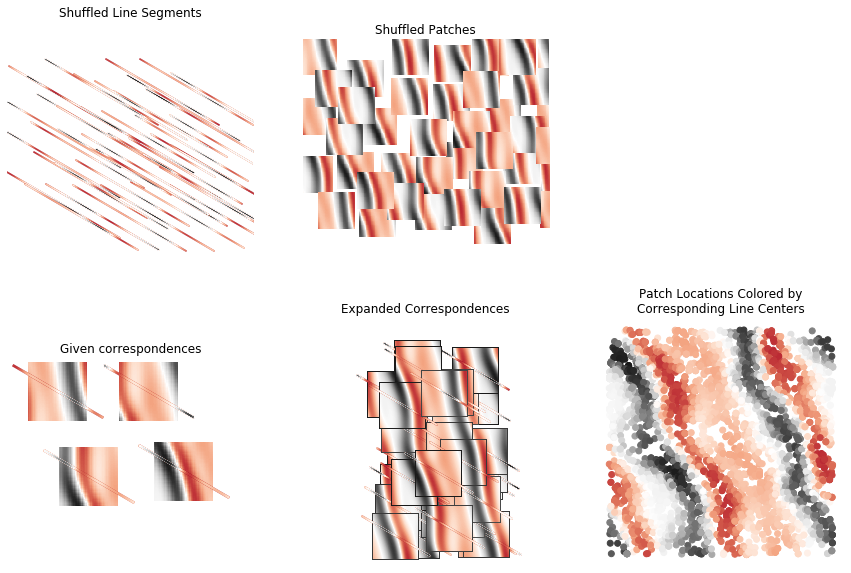

In [7]:
import matplotlib.transforms as mtransforms

plt.figure(figsize=(15, 10))

## Subplot 1: Shuffled line segments on the left, patches on the right

vmax = np.max(np.abs(pdes[0].I))
vmin = -vmax
ax = plt.subplot(231)
N = 40
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs, _ = getGreedyPerm(locs, N)
locs = locs[idxs, :]
idxs = np.random.permutation(pdes[0].Xs.size)

for i in range(N):
    p = np.reshape(pdes[0].patches[idxs[i], :], pdes[0].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([0, 150])
plt.ylim([150, 0])
plt.axis('off')
plt.title("Shuffled Line Segments")


ax = plt.subplot(232)
locs = np.array([pdes[0].Xs, pdes[0].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs, _ = getGreedyPerm(locs, N)
locs = locs[idxs, :]
print(locs.shape)
locs -= np.mean(locs, 0)
locs *= 3
idxs = np.random.permutation(pdes[1].Xs.size)
for i in range(N):
    p = np.reshape(pdes[1].patches[idxs[i], :], pdes[1].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([-150, 150])
plt.ylim([160, -100])
plt.axis('off')
plt.title("Shuffled Patches")

ax = plt.subplot(234)
locs /= 3
for i in range(corresp.shape[0]):
    print(locs[i, :])
    i1, i2 = corresp[i, :]
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    # Draw square patch first
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[0:2, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)

    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
plt.xlim([-90, 100])
plt.ylim([70, -60])
plt.axis('off')
plt.title("Given correspondences")

ax = plt.subplot(235)
N = 30
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
idxs, _ = getGreedyPerm(locs, N)
correspfinal = idxMin[-1]
for i1 in idxs[0:N]:
    i2 = correspfinal[i1]
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    p2t = np.max(p2)*np.ones((p2.shape[0]+2, p2.shape[0]+2))
    p2t[1:-1, 1:-1] = p2
    p2 = p2t
    # Draw square patch first
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[0:2, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i2, :]
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)

    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i2, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
plt.xlim([-75, 150])
plt.ylim([240, -10])
plt.axis('off')
plt.title("Expanded Correspondences")


plt.subplot(236)
f_interp = pdes[0].getInterpolator()
patch_centers = f_interp(pdes[0].Ts.flatten(), pdes[0].Xs.flatten(), grid=False)
plt.scatter(pdes[1].Xs[correspfinal], pdes[1].Ts[correspfinal], c=patch_centers, cmap='RdGy', vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.axis('off')
plt.title("Patch Locations Colored by\nCorresponding Line Centers")

plt.savefig("LinesToPatchesAligned.svg", bbox_inches='tight')